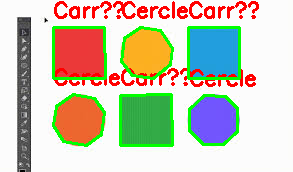

In [ ]:
import cv2
import numpy as np
import gradio as gr
from PIL import Image

def detect_shapes(image):
    """
    Detect shapes in an image and return the annotated result
    """
    # Convert PIL Image to OpenCV format
    img = np.array(image)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

    # Create a copy for drawing contours
    img_contour = img.copy()

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian blur
    blur = cv2.GaussianBlur(gray, (5, 5), 1)

    # Edge detection
    edges = cv2.Canny(blur, 50, 150)

    # Find contours
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    shapes_detected = []

    # Process each contour
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area > 500:  # Filter small contours
            # Approximate contour to polygon
            epsilon = 0.02 * cv2.arcLength(cnt, True)
            approx = cv2.approxPolyDP(cnt, epsilon, True)

            # Get bounding rectangle
            x, y, w, h = cv2.boundingRect(approx)

            # Determine shape based on number of vertices
            nb_sommets = len(approx)
            shape = "Indéfini"

            if nb_sommets == 3:
                shape = "Triangle"
            elif nb_sommets == 4:
                ratio = w / float(h)
                shape = "Carré" if 0.95 < ratio < 1.05 else "Rectangle"
            elif nb_sommets > 6:
                shape = "Cercle"

            # Draw contour and label
            cv2.drawContours(img_contour, [approx], 0, (0, 255, 0), 2)
            cv2.putText(img_contour, shape, (x, y - 10),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

            shapes_detected.append({
                'shape': shape,
                'vertices': nb_sommets,
                'area': int(area),
                'position': f"({x}, {y})"
            })

    # Convert back to RGB for display
    img_contour = cv2.cvtColor(img_contour, cv2.COLOR_BGR2RGB)

    # Create summary text
    summary = f"Détecté {len(shapes_detected)} forme(s):\n"
    for i, shape_info in enumerate(shapes_detected, 1):
        summary += f"{i}. {shape_info['shape']} - {shape_info['vertices']} sommets - Aire: {shape_info['area']} pixels\n"

    return img_contour, summary

# Create Gradio interface
def create_interface():
    with gr.Blocks(title="Détecteur de Formes Géométriques", theme=gr.themes.Soft()) as interface:
        gr.Markdown("# 🔍 Détecteur de Formes Géométriques")
        gr.Markdown("Téléchargez une image pour détecter et identifier les formes géométriques (triangles, carrés, rectangles, cercles)")

        with gr.Row():
            with gr.Column():
                input_image = gr.Image(
                    type="pil",
                    label="📸 Image d'entrée",
                    height=400
                )

                detect_btn = gr.Button(
                    "🔍 Détecter les formes",
                    variant="primary",
                    size="lg"
                )

                gr.Markdown("### Instructions:")
                gr.Markdown("""
                - Téléchargez une image contenant des formes géométriques
                - Les formes doivent être suffisamment grandes (aire > 500 pixels)
                - Fonctionne mieux avec des formes aux contours nets
                - Supporte: triangles, carrés, rectangles, cercles
                """)

            with gr.Column():
                output_image = gr.Image(
                    label="🎯 Formes détectées",
                    height=400
                )

                output_text = gr.Textbox(
                    label="📊 Résumé de détection",
                    lines=8,
                    max_lines=15
                )

        # Examples section
        gr.Markdown("### 📝 Exemples")
        gr.Examples(
            examples=[
                # You can add example images here if you have them
                # ["path/to/example1.jpg"],
                # ["path/to/example2.jpg"],
            ],
            inputs=input_image,
            label="Cliquez sur un exemple pour le tester"
        )

        # Event handlers
        detect_btn.click(
            fn=detect_shapes,
            inputs=input_image,
            outputs=[output_image, output_text]
        )

        input_image.change(
            fn=detect_shapes,
            inputs=input_image,
            outputs=[output_image, output_text]
        )

    return interface

# Launch the app
if __name__ == "__main__":
    interface = create_interface()
    interface.launch(
        share=True,
        server_name="0.0.0.0",
        server_port=7860
    )
